IMPORTANT LIBERARIES

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as re
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import label_binarize

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

DATA_SET 

In [42]:
train_df = pd.read_csv("Emotion_dataset/training.csv")

In [43]:
test_df = pd.read_csv("Emotion_dataset/test.csv")

UNDERSTANDING THE DATASET AND TRYING TO GET TO KNOW THE DATA AND TRYING TO UNDERSTAND THE DATA BY SOME METHOD

In [44]:
train_df['label'].unique()

array([0, 3, 2, 5, 4, 1])

In [45]:
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [46]:
# Load the dataset
train_df = pd.read_csv("Emotion_dataset/training.csv")

# Count the occurrences of each label
label_counts = train_df['label'].value_counts()

# Display the counts
print(label_counts)

label
1    6066
0    5216
3    2434
4    2149
2    1482
5     653
Name: count, dtype: int64


UNIQUE VALUES IN THE DATA_SET TO FIND HOW MANY EMOTION IS UESED IN THIS CASE THER ARE THE TOTAL OF 5 UNIQUE NUMBERS SO THERE ARE 5 EMOTION ARE USED IN THIS DATA_SET

SO AFTER KNOWING THE UNIQUE IN THE LABEL NOW WE NEED TO FIND THE THE MEANING BEHIND THE LABEL NUMBERS FOR EXAMPLE THE NUMBER 0 IN THE LABEL FEATURE OR TARGET FEATURE REPRESENT A KIND OF EMOTION BUT WE DID'T KNOW THAT BUT WE CAN GET BY GETTING SOME IDEAS FROM THE TEXT FEATURES.

In [47]:
# Get 5 random sentences per label
samples_per_label = 5
label_samples = {}

for label in range(1, 6):  # Assuming labels are 1-5
    sentences = train_df[train_df['label'] == label]['text'].tolist()
    label_samples[label] = random.sample(sentences, min(samples_per_label, len(sentences)))

# Display sampled sentences
for label, samples in label_samples.items():
    print(f"Label {label} samples:")
    for sentence in samples:
        print(f"- {sentence}")
    print("\n")

Label 1 samples:
- i get frustrated with the fact that i don t always feel appreciative for the hand i ve been dealt and for the people i love in life
- i feel so friggin blessed with a wonderful career and family
- i feel like my husband is being sweet with me again
- i wonder what the other students in my classes feel of my being fearless to throw answers out there
- i fall off when my uncle hits so i cant imagine what it must feel like to go mph other than cool and possibly painful


Label 2 samples:
- i feel like blair just wants to be loved
- i wear this story as a protection from feeling the vulnerability of merely loving and depending on another human
- i just have a feeling it will be pretty in this lovely yarn and im stash busting as well which is a bonus
- i feel like ive been running around without any sense of direction or longing of purpose or life goals
- i love how the smells can make you feel so nostalgic


Label 3 samples:
- i am feeling resentful because i am thinking

TEXT PREPROCESSING:

HERE WE CONVERT THE TEXT TO TO LOWER CASE THEN REMOVE THE PUNCTUATION AND SPECIAL CHARACTER AND CONSIDER STEMMING OR LEMMATIZATION TO NORMALISZE WORDS THEN WE REMOVE THE STOP WORDS AND KEEP THOSE WHICH IS IMPORTANT FOR EMOTION DETECTION

In [48]:
# Initialize NLTK's WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Custom stopwords list (modify as needed)
stop_words = set(stopwords.words('english'))
keep_words = {
    'not', 'no', 'very', 'too', 'but', 'and', 'or', 'so', 'yet',
    'still', 'though', 'just', 'even', 'although', 'despite', 'unless'
}
stop_words = stop_words - keep_words

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs, mentions, and special characters
    text = re.sub(r'http\S+|www\S+|@\w+|[^\w\s]', '', text)
    
    # 3. Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 4. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 6. Lemmatization (using NLTK's WordNetLemmatizer)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    
    return " ".join(lemmatized)

# Apply preprocessing to the 'text' column of train_df
test_df['text'] = test_df['text'].apply(preprocess_text)
train_df['text'] = train_df['text'].apply(preprocess_text)
val_df['text'] = val_df['text'].apply(preprocess_text)

In [49]:
train_df.head()

,text,label
0,didnt feel humiliated,0
1,go feeling so hopeless so damned hopeful just ...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,3


FEATURE EXTRACTION:

In [50]:
from sklearn.model_selection import train_test_split

# Train set
X_train = train_df['text']
y_train = train_df['label']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Test set
X_test_final = test_df['text']
y_test_final = test_df['label']
X_test_final, X_val, y_test_final, y_val = train_test_split(X_test_final, y_test_final, test_size=0.2, random_state=42)

# Validation set — split into validation and holdout/test set
X_val_final = val_df['text']
y_val_final = val_df['label']
X_val_final, X_val_holdout, y_val_final, y_val_holdout = train_test_split(X_val_final, y_val_final, test_size=0.2, random_state=42)


TF-IDF: 

A technique that assigns weights to words based on their relevance.

In [51]:

#########################################################
    #TF-IDF Vectorizer (Consistent Processing)
#########################################################
print("\n2. TF-IDF Vectorizer")

# Create isolated copies (using consistent naming)
train_tfidf_copy = train_df.copy()  # Training data copy
test_tfidf_copy = test_df.copy()    # Testing data copy (COMPLETELY SEPARATE)

# --- Training Data Pipeline ---
train_tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = train_tfidf_vectorizer.fit_transform(train_tfidf_copy['text'])  # Fit ONLY on training data

train_tfidf_feature_names = train_tfidf_vectorizer.get_feature_names_out()
train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=train_tfidf_feature_names)
train_tfidf_df['label'] = train_tfidf_copy['label'].values

# --- Testing Data Pipeline ---
X_test_tfidf = train_tfidf_vectorizer.transform(test_tfidf_copy['text'])  # Use the SAME vectorizer

test_tfidf_feature_names = train_tfidf_vectorizer.get_feature_names_out()
test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=test_tfidf_feature_names)
test_tfidf_df['label'] = test_tfidf_copy['label'].values

# Print shapes and verification
print("Training TF-IDF Shape:", X_train_tfidf.shape)
print("Testing TF-IDF Shape:", X_test_tfidf.shape)
print("\nVocabularies are consistent now!")
print("Training vocab size:", len(train_tfidf_vectorizer.vocabulary_))
print("Testing vocab size:", len(train_tfidf_vectorizer.vocabulary_))

train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=train_tfidf_feature_names)
train_tfidf_df['label'] = train_tfidf_copy['label'].values

test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=test_tfidf_feature_names)
test_tfidf_df['label'] = test_tfidf_copy['label'].values

# --- Print final shapes ---
print("Training Final Shape:", train_tfidf_df.shape)
print("Testing Final Shape:", test_tfidf_df.shape)


2. TF-IDF Vectorizer
Training TF-IDF Shape: (18000, 1000)
Testing TF-IDF Shape: (2000, 1000)

Vocabularies are consistent now!
Training vocab size: 1000
Testing vocab size: 1000
Training Final Shape: (18000, 1001)
Testing Final Shape: (2000, 1001)


Applying SMOTE algorithm for balancing the Dataset.

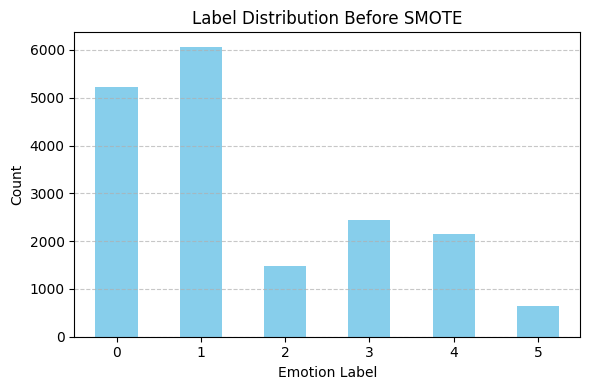

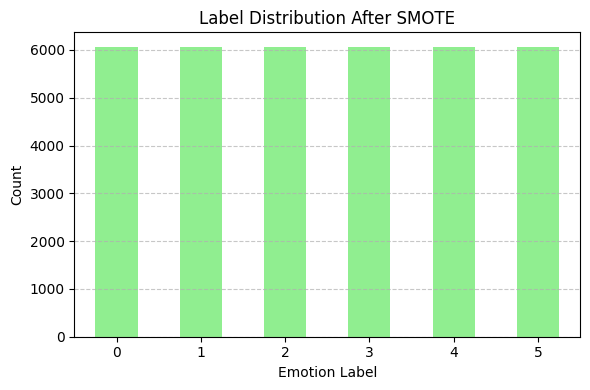

In [52]:
# Step 1: Get TI-IDF features and labels
try:
    X = train_tfidf_df.drop('label', axis=1)
    y = train_tfidf_df['label']
except NameError:
    raise ValueError("'train_final_df' is not defined. Ensure your dataset is available and properly formatted.")

# Plot label distribution BEFORE SMOTE
train_tfidf_df.shape
plt.figure(figsize=(6, 4))
y.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Label Distribution Before SMOTE")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled y to DataFrame for visualization
y_resampled_series = pd.Series(y_resampled)

# Plot label distribution AFTER SMOTE
plt.figure(figsize=(6, 4))
y_resampled_series.value_counts().sort_index().plot(kind='bar', color='lightgreen')
plt.title("Label Distribution After SMOTE")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


From now just model training

best models

LogisticRegression MODEL 


Training LogisticRegression...
LogisticRegression Training Macro F1-Score: 0.9183
LogisticRegression Testing  Macro F1-Score: 0.8061

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       581
           1       0.89      0.86      0.88       695
           2       0.64      0.78      0.70       159
           3       0.83      0.84      0.84       275
           4       0.85      0.79      0.82       224
           5       0.61      0.82      0.70        66

    accuracy                           0.85      2000
   macro avg       0.79      0.83      0.81      2000
weighted avg       0.86      0.85      0.85      2000



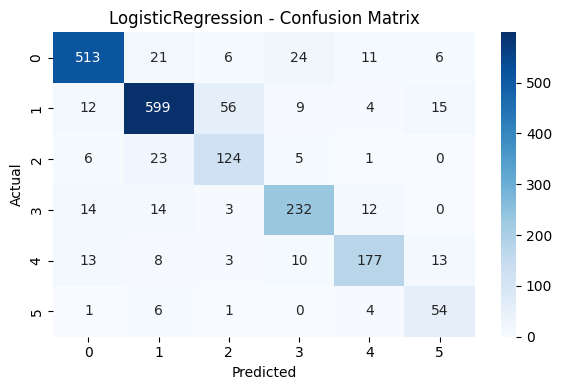

In [53]:
# 1. Use SMOTE-Resampled Dataset for Training and Testing
try:
    X_train = X_resampled  # Assume SMOTE has already been applied externally
    y_train = y_resampled
except NameError:
    raise ValueError("SMOTE-resampled data 'X_resampled' and 'y_resampled' not found.")

try:
    X_test = test_tfidf_df.drop('label', axis=1)
    y_test = test_tfidf_df['label']
except NameError:
    raise ValueError("'test_final_df' must be defined and contain a 'label' column.")

# Define Models
models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=100, random_state=42, solver='saga'),
}

# Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    best_model, best_score = None, 0
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute macro F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"{name} Training Macro F1-Score: {train_f1:.4f}")
        print(f"{name} Testing  Macro F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results[name] = {
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1,
            'model': model
        }

        # Update best model
        if test_f1 > best_score:
            best_score = test_f1
            best_model = model

        # Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    return best_model, results

# Run Evaluation
best_model, results = evaluate_models(models, X_train, y_train, X_test, y_test)


XGBoost MODEL


Training XGBoost...


C:\Users\go2af\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:15:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Training Macro F1-Score: 0.9421
XGBoost Testing  Macro F1-Score: 0.8131

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       581
           1       0.86      0.87      0.87       695
           2       0.69      0.82      0.75       159
           3       0.88      0.83      0.85       275
           4       0.83      0.83      0.83       224
           5       0.58      0.79      0.67        66

    accuracy                           0.85      2000
   macro avg       0.80      0.84      0.81      2000
weighted avg       0.86      0.85      0.86      2000



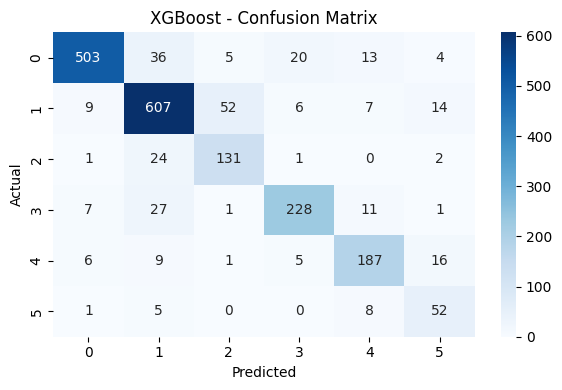

In [44]:
# 1. Use SMOTE-Resampled Dataset for Training and Testing
try:
    X_train = X_resampled  # Assume SMOTE has already been applied externally
    y_train = y_resampled
except NameError:
    raise ValueError("SMOTE-resampled data 'X_resampled' and 'y_resampled' not found.")

try:
    X_test = test_tfidf_df.drop('label', axis=1)
    y_test = test_tfidf_df['label']
except NameError:
    raise ValueError("'test_final_df' must be defined and contain a 'label' column.")

# Define XGBoost model
models = {
    'XGBoost': XGBClassifier(
        objective='multi:softmax',  # for multi-class classification
        random_state=42,
        eval_metric='mlogloss',  # metric for multi-class
        use_label_encoder=False
    ),
}

# Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    best_model, best_score = None, 0
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute macro F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"{name} Training Macro F1-Score: {train_f1:.4f}")
        print(f"{name} Testing  Macro F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results[name] = {
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1,
            'model': model
        }

        # Update best model
        if test_f1 > best_score:
            best_score = test_f1
            best_model = model

        # Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    return best_model, results

# Run Evaluation
best_model, results = evaluate_models(models, X_train, y_train, X_test, y_test)

HistGradientBoosting MODEL


Training HistGradientBoosting...
HistGradientBoosting Training Macro F1-Score: 0.9605
HistGradientBoosting Testing  Macro F1-Score: 0.8120

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       581
           1       0.87      0.88      0.87       695
           2       0.69      0.79      0.73       159
           3       0.84      0.82      0.83       275
           4       0.82      0.83      0.83       224
           5       0.62      0.77      0.69        66

    accuracy                           0.86      2000
   macro avg       0.80      0.83      0.81      2000
weighted avg       0.86      0.86      0.86      2000



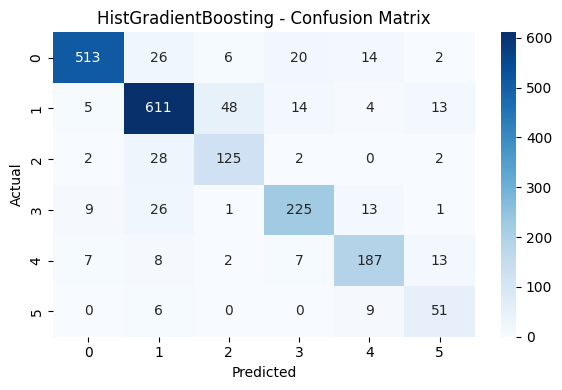

In [46]:
# 1. Use SMOTE-Resampled Dataset for Training and Testing
try:
    X_train = X_resampled  # Assume SMOTE has already been applied externally
    y_train = y_resampled
except NameError:
    raise ValueError("SMOTE-resampled data 'X_resampled' and 'y_resampled' not found.")

try:
    X_test = test_tfidf_df.drop('label', axis=1)
    y_test = test_tfidf_df['label']
except NameError:
    raise ValueError("'test_final_df' must be defined and contain a 'label' column.")

# Define HistGradientBoosting model
models = {
    'HistGradientBoosting': HistGradientBoostingClassifier(
        random_state=42
    ),
}

# Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    best_model, best_score = None, 0
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute macro F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"{name} Training Macro F1-Score: {train_f1:.4f}")
        print(f"{name} Testing  Macro F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results[name] = {
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1,
            'model': model
        }

        # Update best model
        if test_f1 > best_score:
            best_score = test_f1
            best_model = model

        # Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    return best_model, results

# Run Evaluation
best_model, results = evaluate_models(models, X_train, y_train, X_test, y_test)

CatBoost MODEL


Training CatBoost...
CatBoost Training Macro F1-Score: 0.9170
CatBoost Testing  Macro F1-Score: 0.8160

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       581
           1       0.87      0.88      0.87       695
           2       0.68      0.83      0.75       159
           3       0.87      0.82      0.85       275
           4       0.82      0.82      0.82       224
           5       0.59      0.85      0.70        66

    accuracy                           0.86      2000
   macro avg       0.80      0.84      0.82      2000
weighted avg       0.87      0.86      0.86      2000



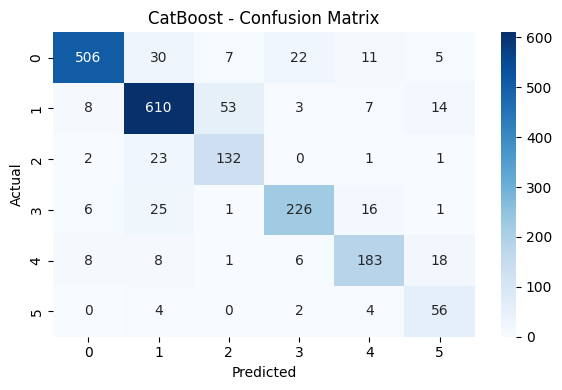

In [35]:
# 1. Use SMOTE-Resampled Dataset for Training and Testing
try:
    X_train = X_resampled  # Assume SMOTE has already been applied externally
    y_train = y_resampled
except NameError:
    raise ValueError("SMOTE-resampled data 'X_resampled' and 'y_resampled' not found.")

try:
    X_test = test_tfidf_df.drop('label', axis=1)
    y_test = test_tfidf_df['label']
except NameError:
    raise ValueError("'test_final_df' must be defined and contain a 'label' column.")

# Define CatBoost model
models = {
    'CatBoost': CatBoostClassifier(verbose=0,random_state=42),
}

# Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    best_model, best_score = None, 0
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute macro F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"{name} Training Macro F1-Score: {train_f1:.4f}")
        print(f"{name} Testing  Macro F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results[name] = {
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1,
            'model': model
        }

        # Update best model
        if test_f1 > best_score:
            best_score = test_f1
            best_model = model

        # Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    return best_model, results

# Run Evaluation
best_model, results = evaluate_models(models, X_train, y_train, X_test, y_test)

LightGBM MODEL


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 67837
[LightGBM] [Info] Number of data points in the train set: 36396, number of used features: 1000
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
LightGBM Training Macro F1-Score: 0.9588
LightGBM Testing  Macro F1-Score: 0.8118

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       581
           1       0.86      0.87      0.87       695
           2      

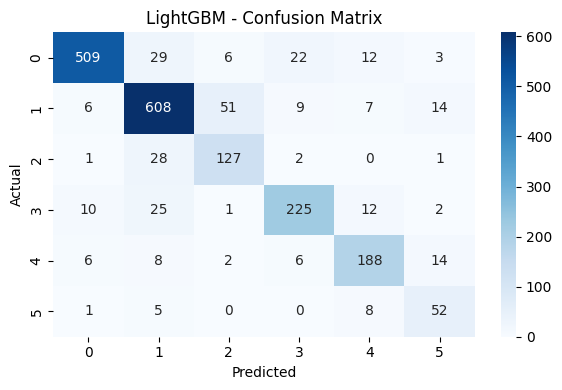

In [36]:
# 1. Use SMOTE-Resampled Dataset for Training and Testing
try:
    X_train = X_resampled  # Assume SMOTE has already been applied externally
    y_train = y_resampled
except NameError:
    raise ValueError("SMOTE-resampled data 'X_resampled' and 'y_resampled' not found.")

try:
    X_test = test_tfidf_df.drop('label', axis=1)
    y_test = test_tfidf_df['label']
except NameError:
    raise ValueError("'test_final_df' must be defined and contain a 'label' column.")

# Define LightGBM model
models = {
    'LightGBM': LGBMClassifier(
        random_state=42
    ),
}

# Evaluation Function
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = {}
    best_model, best_score = None, 0
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Compute macro F1 scores
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        test_f1 = f1_score(y_test, y_test_pred, average='macro')

        print(f"{name} Training Macro F1-Score: {train_f1:.4f}")
        print(f"{name} Testing  Macro F1-Score: {test_f1:.4f}")

        print("\nClassification Report (Test Set):")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results[name] = {
            'train_f1_macro': train_f1,
            'test_f1_macro': test_f1,
            'model': model
        }

        # Update best model
        if test_f1 > best_score:
            best_score = test_f1
            best_model = model

        # Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"{name} - Confusion Matrix")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

    return best_model, results

# Run Evaluation
best_model, results = evaluate_models(models, X_train, y_train, X_test, y_test)
